#### Methodology to address fundamental problem 1 itemized in Issue 1024 - follow-up compare tabulations and relative household burden. This time I extend the 12-11 notebook to look at how the percentile ranks affects the proportion of tracts considered as burdened versus the current methodology.

### Indicator reviewed: 

Socioeconomic Factors Indicator reviewed
*  [Extreme Housing Burden](#housingburden)

#### Packages

In [1]:
import math
import numpy as np
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### ETL process for acquiring relevant tables

#### NOTE: If you ran the ETL Process to acquire Table 8 in the other notebook of this draft PR you do not need to run the ETL cell block again

In [3]:
# Copy and adapt certain sections of code from data_pipeline.utils 

def download_hud_dataset():
    DOWNLOAD_FILENAME = "HUD_ZIPPED.csv"
    HOUSING_FTP_URL = "https://www.huduser.gov/portal/datasets/cp/2014thru2018-140-csv.zip"    
    response = requests.get(HOUSING_FTP_URL, verify=True)
    if response.status_code == 200:
        file_contents = response.content
    else:
        sys.exit(
            f"HTTP response {response.status_code} from url {file_url}. Info: {response.content}"
        )

    # Write the contents to disk.
    file = open(DOWNLOAD_FILENAME, "wb")
    file.write(file_contents)
    file.close()
    
def extract_zipped_download(zip_file_path, unzipped_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(unzipped_path)
    # cleanup temporary file
    os.remove(zip_file_path)
    
def up_one_directory(path):
    try:
        # from Python 3.6
        parent_dir = Path(path).parents[1]
        # for Python 3.4/3.5, use str to convert the path to string
        # parent_dir = str(Path(path).parents[1])
        shutil.move(path, parent_dir)
    except IndexError:
        # no upper directory
        pass

CURRENT_DIRECTORY = os.getcwd()
download_hud_dataset()
extract_zipped_download(CURRENT_DIRECTORY + "/HUD_ZIPPED.csv", CURRENT_DIRECTORY)  
up_one_directory(CURRENT_DIRECTORY + "/140/Table8.csv")
shutil.rmtree("./140/")

### Extreme Housing Burden <a id='housingburden'></a>

The Extreme Housing Burden indicator represents the proportion of low-income households that have to spend more than half their income on rent. These households experience higher levels of stress, report lower health, and may delay medical treatment because of its high cost.

The Extreme Housing Burden indicator measures the percent of households in a census tract that are:

1. Making less than 80% of the Area Median Family Income as determined by the Department of Housing and Urban Development (HUD), and
2. Paying greater than 50% of their income to housing costs. 

This data is sourced from the 2014-2018 Comprehensive Housing Affordability Strategy dataset from the Department of Housing and Urban Development (HUD) using the census tract geographic summary level, and contains cost burdens for households by percent HUD-adjusted median family income (HAMFI) category. This data can be found [here](https://www.huduser.gov/portal/datasets/cp.html). 

Because CHAS data is based on American Communities Survey (ACS) estimates, which come from a sample of the population, they may be unreliable if based on a small sample or population size.

The standard error and relative standard error were used to evaluate the reliability of each estimate using CalEnviroScreen’s methodology. 

Census tract estimates that met either of the following criteria were considered reliable and included in the analysis [(CalEnviroScreen, 2017, page 129)](https://oehha.ca.gov/media/downloads/calenviroscreen/report/ces3report.pdf ):

- Relative standard error less than 50 (meaning the standard error was less than half of the estimate), OR 
- Standard error less than the mean standard error of all census tract estimates 

Formulas for calculating the standard error of sums, proportions, and ratio come from the [American Communities Survey Office](https://www2.census.gov/programs-surveys/acs/tech_docs/accuracy/MultiyearACSAccuracyofData2013.pdf).

Note that this code creates a score and rank by state, for every state.

The relevant variables in table 8 of the CHAS dataset are the following (CHAS data dictionary available [here](https://www.huduser.gov/portal/datasets/cp/CHAS-data-dictionary-14-18.xlsx)):

|   Name  |                          Label                      |
|---------|-----------------------------------------------------|
|T1_est1  |                                   Total Occupied housing units                                      | 
|T8_est10 |            Owner occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est23 |Owner occupied greater than 30% but less than or equal to 50% of HAMFI	cost burden greater than 50%|
|T8_est36 |Owner occupied	greater than 50% but less than or equal to 80% of HAMFI	cost burden greater than 50%|
|T8_est76 |           Renter occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est89 |Renter occupied	greater than 30% but less than or equal to 50% of HAMFI	cost burden greater than 50%|
|T8_est102|Renter occupied	greater than 50% but less than or equal to 80% of HAMFI	cost burden greater than 50%|
 

### Below I also propose an alternate means for ranking census tracts
### These steps are outlined and commented below

In [2]:
# Read in the data from https://www.huduser.gov/portal/datasets/cp.html
housing = pd.read_csv("Table8.csv", 
                      encoding = "ISO-8859-1",  
                      dtype = {'Tract_ID': object, 'st': object, 'geoid': object})

# Remove data for states that aren't included in the census (e.g. American Samoa, Guam, etc.):
housing.drop(housing.loc[housing['st'] == '72'].index, inplace = True)

# Combine owner and renter occupied low-income households that make less than 80% of HAMFI into one variable
housing['summed'] = (housing['T8_est10'] + 
                     housing['T8_est23'] + 
                     housing['T8_est36'] + 
                     housing['T8_est76'] + 
                     housing['T8_est89'] + 
                     housing['T8_est102'])

# Create a variable for the standard error of the summed variables
housing['summed_se'] = np.sqrt((housing['T8_moe10'] / 1.645)**2 + 
                                (housing['T8_moe23'] / 1.645)**2 + 
                                (housing['T8_moe36'] / 1.645)**2 + 
                                (housing['T8_moe76'] / 1.645)**2 + 
                                (housing['T8_moe89'] / 1.645)**2 + 
                                (housing['T8_moe102'] / 1.645)**2)

# Remove the first 7 digits in the FIPS Census Tract ID 
housing['geoid'] = housing['geoid'].str[-11:]

# Find the estimate of the proportion of the population that is heavily rent burdened
housing['hbrd_score'] = housing['summed'] / housing['T8_est1']

# Change rates where the population is 0 to nan
housing['hbrd_score'].replace(np.inf, np.nan, inplace = True)

# Create function for calculating the standard error, using the proportions standard error formula
#  if the value under the radical is negative, use the ratio standard error formula
def se_prop(x, y, se_x, moe_y): 
    se_y = moe_y / 1.645
    test = se_x**2 - (((x**2)/(y**2))*((se_y)**2))
    se = np.where(test < 0,
                   (1/y) * np.sqrt(se_x**2 + (((x**2)/(y**2))*(se_y**2))), 
                   (1/y) * np.sqrt(se_x**2 - (((x**2)/(y**2))*(se_y**2))))
    return se

housing['se'] = se_prop(housing['summed'], housing['T8_est1'], housing['summed_se'], housing['T8_moe1'])

# Calculate the relative standard error
housing['rse'] = housing['se'] / housing['hbrd_score']*100

# Change infinite rse's where the housing burden is 0 to np.nan
housing['rse'].replace(np.inf, np.nan, inplace = True)

# Calculate the mean standard error for each state
housing['mean_state_se'] = np.zeros(len(housing))

for state in housing['st'].unique():
    mean_se = np.mean(housing[housing['st'] == state]['se'])
    housing['mean_state_se'].loc[housing['st'] == state] = mean_se
    
# Find census tract estimates that meet both of the following criteria and are thus considered unreliable estimates: 
# RSE less than 50 AND
# SE less than the mean state SE or housing burdened low income households
# Convert these scores to nan
housing.loc[(housing['rse'] >= 50) & (housing['rse'] >= housing['mean_state_se']), 'hbrd_score'] = np.nan

# Rename columns
housing = housing.rename(columns = {'geoid' :'FIPS_tract_id',
                                    'st' : 'state'
                                   })

# Calculate percentile rank for census tracts with a score above 0, set percentile to 0 if score is 0, for each state
housing['hbrd_rank'] = housing[
            housing['hbrd_score'] != 0][['hbrd_score',
                'state']].groupby('state').rank( 
                na_option = 'keep', 
                pct = True) * 100

housing.loc[housing['hbrd_score'] == 0, 'hbrd_rank'] = 0

# Create final housing burden df
housingburden = housing.copy()

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [3]:
housingburden.head()

,source,sumlevel,FIPS_tract_id,name,state,cnty,tract,T8_est1,T8_est2,T8_est3,...,T8_moe131,T8_moe132,T8_moe133,summed,summed_se,hbrd_score,se,rse,mean_state_se,hbrd_rank
0,2014thru2018,140,01001020100,"Census Tract 201, Autauga County, Alabama",01,1,20100,765,570,50,...,12,12,12,80,31.721807,0.104575,0.041032,39.237314,0.036604,46.298077
1,2014thru2018,140,01001020200,"Census Tract 202, Autauga County, Alabama",01,1,20200,720,465,65,...,12,12,12,138,45.531874,0.191667,0.061614,32.146659,0.036604,83.269231
2,2014thru2018,140,01001020300,"Census Tract 203, Autauga County, Alabama",01,1,20300,1295,840,60,...,12,12,12,170,53.722921,0.131274,0.040927,31.176999,0.036604,63.653846
3,2014thru2018,140,01001020400,"Census Tract 204, Autauga County, Alabama",01,1,20400,1640,1260,15,...,12,12,12,145,46.288510,0.088415,0.027822,31.467397,0.036604,34.615385
4,2014thru2018,140,01001020500,"Census Tract 205, Autauga County, Alabama",01,1,20500,4175,2320,175,...,17,17,17,595,147.221693,0.142515,0.034760,24.390193,0.036604,68.221154


In [4]:
housingburden.shape

(73056, 280)

### As desired we see a uniform distribution for the percentile rank for burdened households

### Now we compute for a baseline comparison 

In [5]:
# Owner occupied numerator fields
OWNER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est7",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est10",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est20",
    
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est23",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est33",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est36",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
OWNER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est13",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est26",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est39",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est52",
    #   Subtotal
    #   Owner occupied
    #   greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est65",
    #   Subtotal
    #   Owner occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

OWNER_OCCUPIED_POPULATION_FIELD = "T8_est2"
#   Subtotal
#   Owner occupied
#   All
#   All
#   All

OWNER_OCCUPIED_POPULATION_HAMFI_FIELD = "T8_est3"
#   Subtotal
#   Owner occupied 
#   All
#   All
#   All

# Renter occupied numerator fields
RENTER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est73",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est76",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est86",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est89",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est99",
    #   Subtotal
    #   Renter occupied	greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est102",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
RENTER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est79",
    #   Subtotal
    #   Renter occupied	less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est92",
    #   Subtotal
    #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est105",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est118",
    #   Subtotal
    #   Renter occupied	greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est131",
    #   Subtotal
    #   Renter occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

# T8_est68	SubtotalRenter occupied	All	All	All
RENTER_OCCUPIED_POPULATION_FIELD = "T8_est68"

In [6]:
housingburden["current_summed_methodology"] = housingburden[
    OWNER_OCCUPIED_NUMERATOR_FIELDS
].sum(axis=1) + housingburden[RENTER_OCCUPIED_NUMERATOR_FIELDS].sum(axis=1)

In [7]:
housingburden["current_methodology_denominator"] = (
         housingburden[OWNER_OCCUPIED_POPULATION_FIELD]
            + housingburden[RENTER_OCCUPIED_POPULATION_FIELD]
            - housingburden[OWNER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
            - housingburden[RENTER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
)

In [8]:
housingburden["current_methodology_denominator_sans_not_computed"] = (
         housingburden[OWNER_OCCUPIED_POPULATION_FIELD]
            + housingburden[RENTER_OCCUPIED_POPULATION_FIELD]
)

In [9]:
housingburden["current_methodology_percent"] = np.round(
    (housingburden["current_summed_methodology"] / housingburden["current_methodology_denominator"] ), 2) * 100

### Now we construct the distribution of differences in the number of owned and rented burdened households


### Percentiles Comparison

In [10]:
final_df = housingburden[['FIPS_tract_id', 'state','hbrd_rank','hbrd_score', 'summed', 
       'current_summed_methodology', 'T8_est1', 
        "current_methodology_denominator_sans_not_computed",
       'current_methodology_denominator',  'current_methodology_percent']]

##### First notice here that **T8_est1** and **current_methodology_denominator** should represent same or similar aggregates. In general, we cen see that the current computation performed results in a differerntial that undercounts the total occupied and rental households.

In [11]:
final_df["differences_aggregate_denominator"] = (
    final_df["current_methodology_denominator"] - final_df["T8_est1"] 
)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
final_df["differences_aggregate_denominator_sans_not_computed"] = (
    final_df["current_methodology_denominator"] - final_df["T8_est1"] 
)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:title={'center':'Distribution of differences between aggregate totals that normalizes tabulation of poverty households'}, xlabel='Aggregate differences in total owner and renter occupied low-income households < 80%', ylabel='Relative Frequency in Support'>

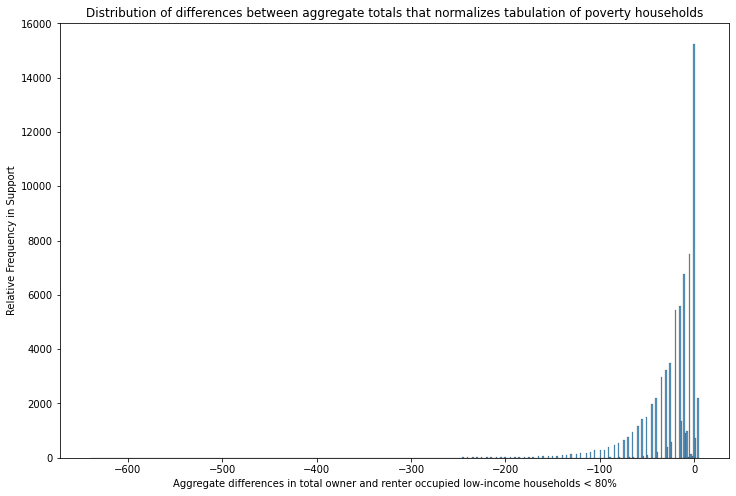

In [13]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between aggregate totals that normalizes tabulation of poverty households')
# Set x-axis label
plt.xlabel('Aggregate differences in total owner and renter occupied low-income households < 80%')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_df["differences_aggregate_denominator"])

<AxesSubplot:title={'center':'Distribution of differences between aggregate totals that normalizes tabulation of poverty households (with removal of not computed fields) '}, xlabel='Aggregate differences in total owner and renter occupied low-income households', ylabel='Relative Frequency in Support'>

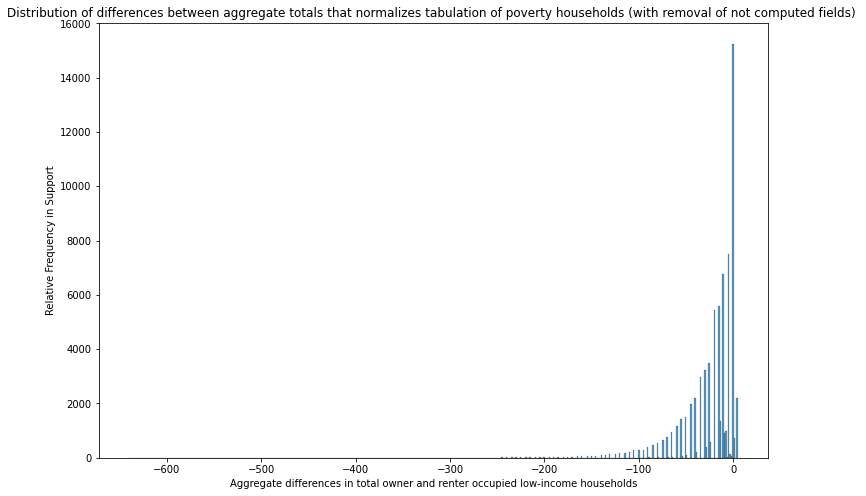

In [14]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between aggregate totals that normalizes tabulation of poverty households (with removal of not computed fields) ')
# Set x-axis label
plt.xlabel('Aggregate differences in total owner and renter occupied low-income households')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_df["differences_aggregate_denominator_sans_not_computed"])

In [15]:
final_df["current_methodology_percentile_rank"] = final_df["current_methodology_percent"].rank(
    pct=True,
    # Set ascending to the parameter value.
    ascending=True,
)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
final_df["new_threshold_exceeded"] = (final_df['hbrd_rank'] >= 90)

final_df["current_threshold_exceeded"] = (final_df[
    'current_methodology_percentile_rank'] >= 0.90)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [46]:
final_df.shape

(73056, 15)

### Only include non-NA tracts for comparison purposes

In [17]:
# first save NA tracts that were considered unreliable
ineligible_tracts = list(final_df[final_df["hbrd_rank"].isna()]["FIPS_tract_id"].values)

#### How many tracts are ineligible according to CalEnvironScreen but are considerd in Score L?




In [61]:
final_current_methodology = final_df[final_df["current_threshold_exceeded"] == True]

In [62]:
final_current_methodology.shape

(7323, 15)

In [67]:
# 53 tracts
final_current_methodology[
    final_current_methodology.FIPS_tract_id.isin(ineligible_tracts)]['current_summed_methodology'].sum()

3145

<AxesSubplot:title={'center':'Distribution of Percentiles (Score L)'}, xlabel='Percentile (although currently not represented as a percentage)', ylabel='Relative Frequency in Support'>

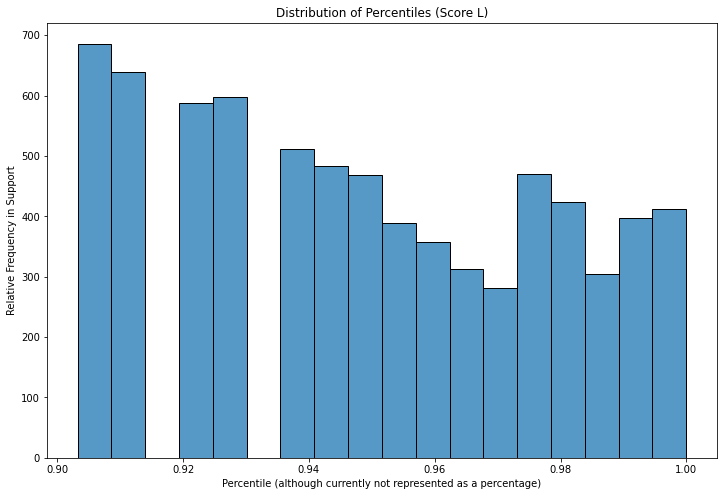

In [22]:
plt.figure(figsize=(12, 8))
plt.title("Distribution of Percentiles (Score L)")
# Set x-axis label
plt.xlabel('Percentile (although currently not represented as a percentage)')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_current_methodology["current_methodology_percentile_rank"])

In [24]:
final_current_methodology["current_threshold_exceeded"].value_counts()

True    7323
Name: current_threshold_exceeded, dtype: int64

In [25]:
final_current_methodology["new_threshold_exceeded"].value_counts()

True     4529
False    2794
Name: new_threshold_exceeded, dtype: int64

In [28]:
final_current_methodology.head()

,FIPS_tract_id,state,hbrd_rank,hbrd_score,summed,current_summed_methodology,T8_est1,current_methodology_denominator_sans_not_computed,current_methodology_denominator,current_methodology_percent,differences_aggregate_denominator,differences_aggregate_denominator_sans_not_computed,current_methodology_percentile_rank,new_threshold_exceeded,current_threshold_exceeded
0,01001020100,01,46.298077,0.104575,80,174,765,765,765,23.0,0,0,0.512833,False,False
1,01001020200,01,83.269231,0.191667,138,177,720,720,720,25.0,0,0,0.575315,False,False
2,01001020300,01,63.653846,0.131274,170,279,1295,1295,1291,22.0,-4,-4,0.479242,False,False
3,01001020400,01,34.615385,0.088415,145,274,1640,1635,1635,17.0,-5,-5,0.289696,False,False
4,01001020500,01,68.221154,0.142515,595,885,4175,4175,4135,21.0,-40,-40,0.444306,False,False


In [26]:
# Inserted after the basic stats definition.
# Load demographic data
import pathlib

DATA_DIR = pathlib.Path.cwd().parent / "data"
COMPARISON_OUTPUTS_DIR = DATA_DIR / "comparison_outputs"

demographics_path = DATA_DIR / "dataset" / "census_acs_2019" / "usa.csv"

demographics_df = pd.read_csv(
    demographics_path,
    dtype={"GEOID10_TRACT": "string"},
)

# Set some field names
BLACK_FIELD_NAME = "Black or African American alone"
AMERICAN_INDIAN_FIELD_NAME = "American Indian and Alaska Native alone"
ASIAN_FIELD_NAME = "Asian alone"
HAWAIIAN_FIELD_NAME = "Native Hawaiian and Other Pacific alone"
TWO_OR_MORE_RACES_FIELD_NAME = "Two or more races"
NON_HISPANIC_WHITE_FIELD_NAME = "Non-Hispanic White"
HISPANIC_FIELD_NAME = "Hispanic or Latino"
PERCENT_PREFIX = "Percent "

RE_OUTPUT_FIELDS = [
    BLACK_FIELD_NAME,
    AMERICAN_INDIAN_FIELD_NAME,
    ASIAN_FIELD_NAME,
    HAWAIIAN_FIELD_NAME,
    TWO_OR_MORE_RACES_FIELD_NAME,
    NON_HISPANIC_WHITE_FIELD_NAME,
    HISPANIC_FIELD_NAME,
]

RE_PERCENT_OUTPUT_FIELDS = [PERCENT_PREFIX + field for field in RE_OUTPUT_FIELDS]

columns_to_keep = (
    ["GEOID10_TRACT"]
    + RE_OUTPUT_FIELDS
    + RE_PERCENT_OUTPUT_FIELDS
    + ['Percent of individuals < 200% Federal Poverty Line', 
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
        'Percent enrollment in college or graduate school',
        'Linguistic isolation (percent)']
)

# Join the demographics in.
merged_df = final_current_methodology.merge(
    demographics_df[columns_to_keep],
    left_on="FIPS_tract_id",
    right_on="GEOID10_TRACT",
    how="inner"
)


# Group bys.
demographics_directory = COMPARISON_OUTPUTS_DIR / "demographics_basic_stats"
demographics_directory.mkdir(parents=True, exist_ok=True)

In [27]:
# these are not converted into percent 0 - 100 scale
percent_cols = [x for x in merged_df.columns if 
                'Percent' in x or '(percent)' in x
    ]

merged_df[
    percent_cols] = merged_df[
    percent_cols].apply(lambda x: x * 100)

In [28]:
merged_df.head()

,FIPS_tract_id,state,hbrd_rank,hbrd_score,summed,current_summed_methodology,T8_est1,current_methodology_denominator_sans_not_computed,current_methodology_denominator,current_methodology_percent,...,Percent Asian alone,Percent Native Hawaiian and Other Pacific alone,Percent Two or more races,Percent Non-Hispanic White,Percent Hispanic or Latino,Percent of individuals < 200% Federal Poverty Line,Median value ($) of owner-occupied housing units,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,Linguistic isolation (percent)
0,01015002101,01,99.519231,0.363184,365,483,1005,1000,970,50.0,...,0.030057,0.4208,0.480914,71.145176,0.510971,61.035565,153500,14.425163,68.001261,0.000000
1,01045020700,01,94.711538,0.252174,319,539,1265,1265,1230,44.0,...,3.998741,0.0000,3.369018,30.321159,0.000000,72.012882,76200,20.528911,3.720930,2.184087
2,01047956400,01,96.923077,0.282158,340,625,1205,1200,1180,53.0,...,1.986755,0.0000,0.397351,6.721854,0.000000,81.459854,59000,30.427046,15.017513,1.475694
3,01047956500,01,96.442308,0.272401,380,625,1395,1395,1340,47.0,...,0.000000,0.0000,0.000000,2.659747,0.000000,83.522543,46000,29.666197,3.272871,0.000000
4,01069040600,01,92.884615,0.240000,180,345,750,750,691,50.0,...,0.308483,0.0000,1.850900,12.750643,0.771208,77.870216,52100,24.772727,4.795852,1.041667


In [29]:
import us

mapping = us.states.mapping('fips', 'abbr')

for idx, row in merged_df.iterrows():
    current_row = str(merged_df.loc[idx, 'state'])
    state = mapping.get(current_row, None)
    merged_df.loc[idx, 'state_name'] = state

In [30]:
merged_df.shape

(7323, 36)

In [31]:
grouped_stats = merged_df.groupby(["state_name"]).agg({
       'GEOID10_TRACT': 'nunique',
       'Percent of individuals < 200% Federal Poverty Line': [np.median, np.std],
       'Median value ($) of owner-occupied housing units': [np.median, np.std],
       'Percent individuals age 25 or over with less than high school degree': [np.median, np.std],
       'Percent enrollment in college or graduate school': [np.median, np.std],
       'Percent Black or African American alone': [np.median, np.std],
       'Percent American Indian and Alaska Native alone': [np.median, np.std],
       'Percent Non-Hispanic White': [np.median, np.std], 
      'Linguistic isolation (percent)': [np.median, np.std],
       'Percent Hispanic or Latino': [np.median, np.std],
      'hbrd_rank': [np.median, np.std],
      'current_methodology_percent': [np.median, np.std],
      'current_summed_methodology': [np.median, np.std, np.sum]
}).reset_index()


In [32]:
grouped_stats.columns = [' '.join(col).strip() for col in grouped_stats.columns.values]

In [33]:
grouped_stats.columns

Index(['state_name', 'GEOID10_TRACT nunique',
       'Percent of individuals < 200% Federal Poverty Line median',
       'Percent of individuals < 200% Federal Poverty Line std',
       'Median value ($) of owner-occupied housing units median',
       'Median value ($) of owner-occupied housing units std',
       'Percent individuals age 25 or over with less than high school degree median',
       'Percent individuals age 25 or over with less than high school degree std',
       'Percent enrollment in college or graduate school median',
       'Percent enrollment in college or graduate school std',
       'Percent Black or African American alone median',
       'Percent Black or African American alone std',
       'Percent American Indian and Alaska Native alone median',
       'Percent American Indian and Alaska Native alone std',
       'Percent Non-Hispanic White median', 'Percent Non-Hispanic White std',
       'Linguistic isolation (percent) median',
       'Linguistic isolation (

In [34]:
grouped_stats_states = grouped_stats[[x for x in grouped_stats 
               if "median" in x and 
               "Percent" in x] + ["GEOID10_TRACT nunique", 
                                  'current_summed_methodology sum', "state_name"]]

In [35]:
grouped_stats_states.set_index("state_name", inplace=True)

In [41]:
grouped_stats_states = grouped_stats_states.rename(columns={
'Percent of individuals < 200% Federal Poverty Line median'
    : 'Percent of individuals < 200% Federal Poverty Line (median across all tracts)', 
'Percent individuals age 25 or over with less than high school degree median':
'Percent individuals age 25 or over with less than high school degree (median across all tracts)',    
'Percent enrollment in college or graduate school median'
    :'Percent enrollment in college or graduate school (median across all tracts)',
'Percent Black or African American alone median':
    'Percent Black or African American alone (median across all tracts)',
'Percent American Indian and Alaska Native alone median':
    'Percent American Indian and Alaska Native alone (median across all tracts)',
'Percent Non-Hispanic White median':
    'Percent Non-Hispanic White (median across all tracts)',
'Percent Hispanic or Latino median':
    'Percent Hispanic or Latino (median across all tracts)',
'GEOID10_TRACT nunique': "Total Number of Unique Tracts",
"current_summed_methodology sum": "Total Owned and Rented Burdened Households (Current Aggregation Methodology)"    
})

In [51]:
bar_styled_current = grouped_stats_states.style.bar(
    subset=grouped_stats_states.columns, align='mid', color=['#d65f5f', '#5fba7d'])

In [60]:
bar_styled_current

,Percent of individuals < 200% Federal Poverty Line (median across all tracts),Percent individuals age 25 or over with less than high school degree (median across all tracts),Percent enrollment in college or graduate school (median across all tracts),Percent Black or African American alone (median across all tracts),Percent American Indian and Alaska Native alone (median across all tracts),Percent Non-Hispanic White (median across all tracts),Percent Hispanic or Latino (median across all tracts),Total Number of Unique Tracts,Total Owned and Rented Burdened Households (Current Aggregation Methodology)
state_name,,,,,,,,,
AK,33.563081,4.720497,12.947117,9.149788,1.801696,54.256645,15.934505,5,4355
AL,68.485757,20.849934,6.433350,81.348675,0.000000,11.453744,2.693089,77,39724
AR,69.921935,16.791298,8.452138,61.801242,0.000000,26.096412,6.803653,27,17542
AZ,65.067839,29.374657,7.440958,6.537451,2.668046,28.072206,54.622544,99,72365
CA,54.706685,34.327450,9.255273,5.424582,0.422773,9.312446,65.592064,1571,1118566
CO,54.397168,14.864474,8.997285,5.961738,0.880976,39.045917,34.991773,82,67865
CT,56.117669,23.820310,7.332196,25.349209,0.000000,20.596898,44.744300,130,92624
DC,56.073035,15.024233,6.562113,90.352577,0.000000,2.691445,3.015312,31,19666
DE,63.460533,16.474359,3.823220,54.912055,0.000000,13.655640,9.678878,13,6789


In [57]:
def highlight_medians(s):
    # highliht if the current median is greater than the median of medians for that series
    
    is_greater_than_median = s > s.median()
    return ['color: red; background-color:#7272FE' 
            if cell else '' for cell in is_greater_than_median]

styled = grouped_stats_states.style.apply(highlight_medians)

In [58]:
styled.to_excel("current_methodology_7323.xlsx")

In [59]:
# bar_styled_current.to_excel("current_bar.xlsx")

In [47]:
grouped_stats_states["Total Number of Unique Tracts"].sum()

7323

<AxesSubplot:>

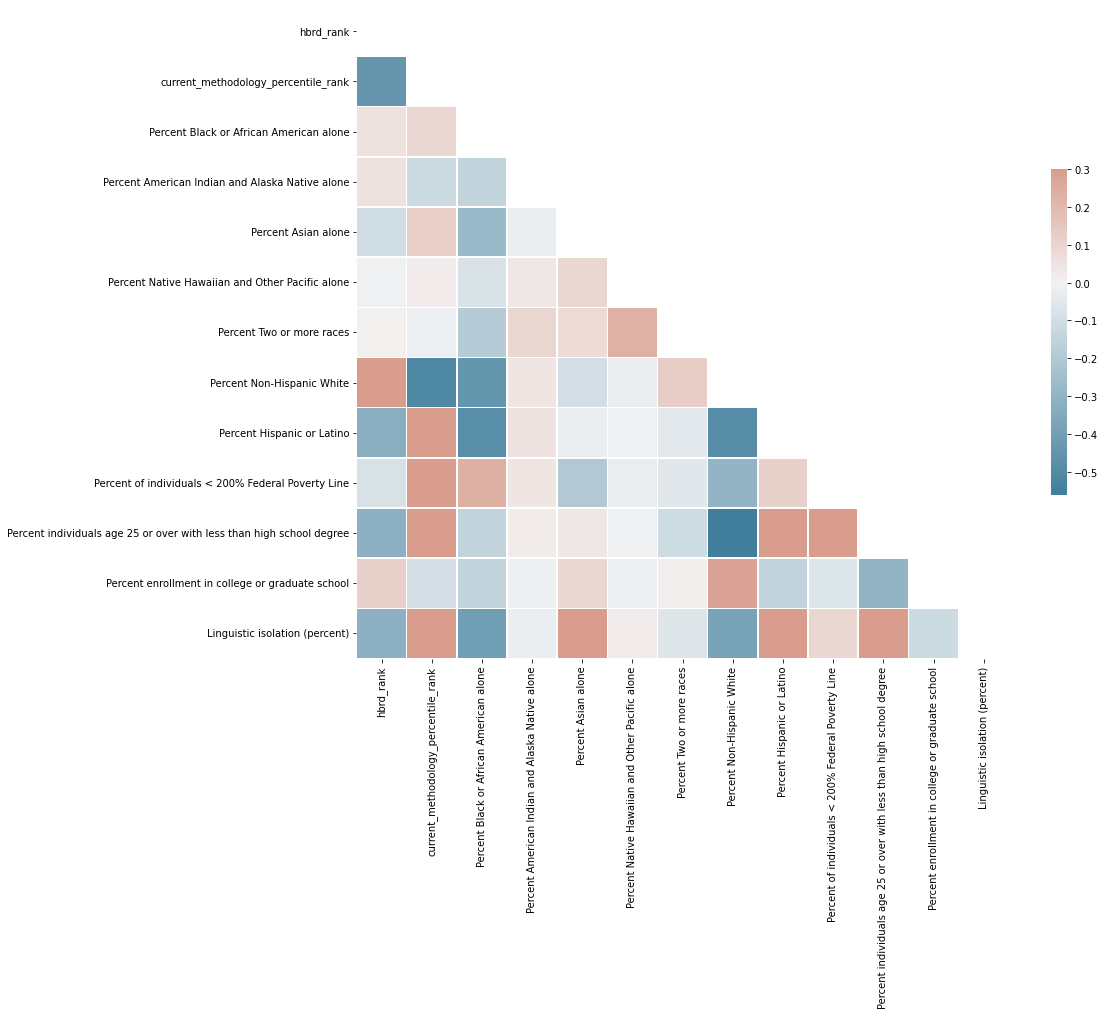

In [49]:
# Compute the correlation matrix
import seaborn as sns
corr = merged_df[["hbrd_rank", 
            "current_methodology_percentile_rank"] + percent_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In the previous, comparing both methodologies. 

1. 